In [37]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import seaborn as sn
import sklearn.metrics as metrics

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#importing dataset
activities=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"]
location='/content/drive/MyDrive/Major_Project/clean_data.csv'
data=pd.read_csv(location)
data.drop(data.columns[[0]],axis=1,inplace=True)
(data.head())

,attr_time_gyro,attr_x_gyro,attr_y_gyro,attr_z_gyro,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,Activity,Label,Subject,Sample_Num
0,1435996982037,-0.815093,0.379639,0.408403,1435996982038,-0.217274,8.125920,1.502960,climbingdown,0,1,7
1,1435996982056,-0.977889,0.365895,0.438336,1435996982056,0.212485,8.208521,0.714071,climbingdown,0,1,7
2,1435996982076,-0.815704,0.554041,0.516832,1435996982077,0.249596,8.118139,-0.342969,climbingdown,0,1,7
3,1435996982095,-0.639164,0.823128,0.550735,1435996982095,0.270545,7.487866,0.112527,climbingdown,0,1,7
4,1435996982114,-0.506606,0.752267,0.589219,1435996982114,-0.014964,7.645285,0.856526,climbingdown,0,1,7


In [40]:
data.columns

Index(['attr_time_gyro', 'attr_x_gyro', 'attr_y_gyro', 'attr_z_gyro',
       'attr_time_acc', 'attr_x_acc', 'attr_y_acc', 'attr_z_acc', 'Activity',
       'Label', 'Subject', 'Sample_Num'],
      dtype='object')

In [41]:
def Range(a):
    return a.max()-a.min();

In [42]:
range_sample=data.groupby(['Activity','Subject','Sample_Num']).apply(Range).add_prefix('range_')
stdev_sample=data.groupby(['Activity','Subject','Sample_Num']).std().add_prefix('std_')
mean_sample=data.groupby(['Activity','Subject','Sample_Num']).mean().add_prefix('mean_')

In [43]:
mean_sample.head()

mean_attr_time_gyro  ...  mean_Label
Activity     Subject Sample_Num                       ...            
climbingdown 1       7                  1.435997e+12  ...         0.0
                     8                  1.435997e+12  ...         0.0
                     9                  1.435997e+12  ...         0.0
                     10                 1.435997e+12  ...         0.0
                     11                 1.435997e+12  ...         0.0

[5 rows x 9 columns]

In [44]:
total_data=pd.concat([stdev_sample,mean_sample,range_sample],axis=1)
total_data.reset_index(inplace=True)

In [45]:
total_data.head()

,Activity,Subject,Sample_Num,std_attr_time_gyro,std_attr_x_gyro,std_attr_y_gyro,std_attr_z_gyro,std_attr_time_acc,std_attr_x_acc,std_attr_y_acc,std_attr_z_acc,std_Label,mean_attr_time_gyro,mean_attr_x_gyro,mean_attr_y_gyro,mean_attr_z_gyro,mean_attr_time_acc,mean_attr_x_acc,mean_attr_y_acc,mean_attr_z_acc,mean_Label,range_attr_time_gyro,range_attr_x_gyro,range_attr_y_gyro,range_attr_z_gyro,range_attr_time_acc,range_attr_x_acc,range_attr_y_acc,range_attr_z_acc,range_Label
0,climbingdown,1,7,577.344583,0.786064,0.611101,0.402885,572.802628,1.028233,3.303459,1.968117,0.0,1.435997e+12,-0.233308,-0.028984,0.144039,1.435997e+12,0.533446,9.213110,2.375641,0.0,1978.0,3.587917,3.262326,1.893377,1977.0,5.589264,15.401898,11.406575,0.0
1,climbingdown,1,8,581.291714,0.942661,0.855090,0.374873,582.030385,1.470079,3.465349,2.752805,0.0,1.435997e+12,0.087604,-0.277429,0.141031,1.435997e+12,0.379439,9.024692,2.418964,0.0,1985.0,4.308738,5.279708,1.747991,1985.0,9.214684,15.316306,18.915391,0.0
2,climbingdown,1,9,579.635665,0.976116,0.803382,0.449999,579.373594,1.566840,3.024721,2.634441,0.0,1.435997e+12,-0.166086,-1.012663,-0.062882,1.435997e+12,0.155054,9.439451,1.640513,0.0,1981.0,4.679228,4.421137,2.178345,1982.0,7.890690,13.982736,21.457434,0.0
3,climbingdown,1,10,582.685275,0.995383,1.088734,0.458140,582.662663,2.012424,3.810429,2.944493,0.0,1.435997e+12,0.167801,-0.480547,0.051044,1.435997e+12,0.311127,8.968662,2.061090,0.0,2024.0,4.831944,7.441561,2.543032,2035.0,14.829087,15.386336,20.637421,0.0
4,climbingdown,1,11,580.331920,1.016299,1.113550,0.605436,581.116097,1.996506,3.389655,2.609269,0.0,1.435997e+12,-0.271014,-0.662130,-0.022941,1.435997e+12,0.001209,9.386025,1.909316,0.0,1959.0,4.633718,6.475477,2.649017,1969.0,11.089942,14.787786,16.913838,0.0


In [46]:
total_data.columns

Index(['Activity', 'Subject', 'Sample_Num', 'std_attr_time_gyro',
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
       'std_attr_time_acc', 'std_attr_x_acc', 'std_attr_y_acc',
       'std_attr_z_acc', 'std_Label', 'mean_attr_time_gyro',
       'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro',
       'mean_attr_time_acc', 'mean_attr_x_acc', 'mean_attr_y_acc',
       'mean_attr_z_acc', 'mean_Label', 'range_attr_time_gyro',
       'range_attr_x_gyro', 'range_attr_y_gyro', 'range_attr_z_gyro',
       'range_attr_time_acc', 'range_attr_x_acc', 'range_attr_y_acc',
       'range_attr_z_acc', 'range_Label'],
      dtype='object')

In [47]:
total_data.Activity.value_counts()

walking         1906
standing        1905
sitting         1882
lying           1853
running         1799
climbingup      1758
climbingdown    1427
jumping          279
Name: Activity, dtype: int64

In [48]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap='YlOrRd'):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(25,10),)
    plt.imshow( cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [49]:
def implement_model(model,title):
    model.fit(X_train,Y_train)
    Y_predicted_train=model.predict(X_train)
    Y_predicted_validate=model.predict(X_validate)
    Y_predicted_final=model.predict(X_final)
    print(f'Training F1 score is: {f1_score(Y_train,Y_predicted_train,average="macro"):.3f}')
    print(f'Validation F1 score is: {f1_score(Y_validate,Y_predicted_validate,average="macro"):.3f}')
    print(f'Testing F1 score is: {f1_score(Y_final,Y_predicted_final,average="macro"):.3f}')
    print(f'Training Accuracy is: {accuracy_score(Y_train,Y_predicted_train):.3f}')
    print(f'Validation Accuracy is: {accuracy_score(Y_validate,Y_predicted_validate):.3f}')
    print(f'Testing Accuracy is: {accuracy_score(Y_final,Y_predicted_final):.3f}')
    cm=confusion_matrix(Y_validate,Y_predicted_validate)
    array=cm
    df_cm = pd.DataFrame(array, index = [i for i in activities],
                  columns = [i for i in activities])
    plt.figure(figsize = (15,15))
    plt.title("VALIDATION CONFUSION MATRIX")
    sn.heatmap(df_cm, annot=True,fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();
    cm=confusion_matrix(Y_final,Y_predicted_final)
    array=cm
    df_cm = pd.DataFrame(array, index = [i for i in activities],
                  columns = [i for i in activities])
    plt.figure(figsize = (15,15))
    plt.title("TEST CONFUSION MATRIX")
    sn.heatmap(df_cm, annot=True,fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [50]:
columns=[
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
         'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
         'range_attr_x_gyro', 'range_attr_y_gyro','range_attr_z_gyro', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']

In [51]:
train_temp=total_data.Subject<=4
validate_temp=total_data.Subject==4
test_temp=total_data.Subject>=5
X_final=total_data[columns][test_temp]
Y_final=total_data.Activity[test_temp]
X_train=total_data[columns][train_temp]
X_validate=total_data[columns][validate_temp]
Y_train=total_data.Activity[train_temp]
Y_validate=total_data.Activity[validate_temp]

In [52]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_validate=scaler.fit_transform(X_validate)
X_final = scaler.transform(X_final)


In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Training F1 score is: 0.934
Validation F1 score is: 0.624
Testing F1 score is: 0.644
Training Accuracy is: 0.935
Validation Accuracy is: 0.683
Testing Accuracy is: 0.695


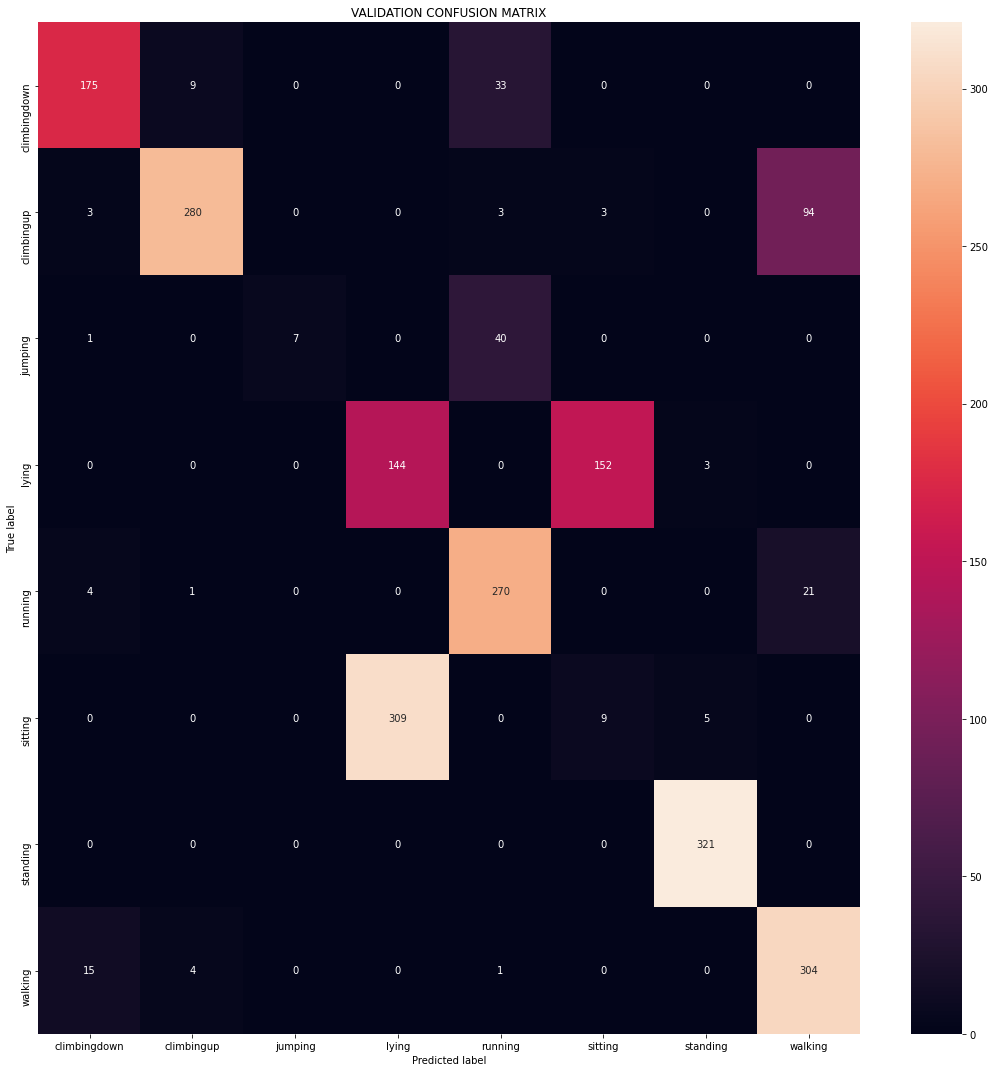

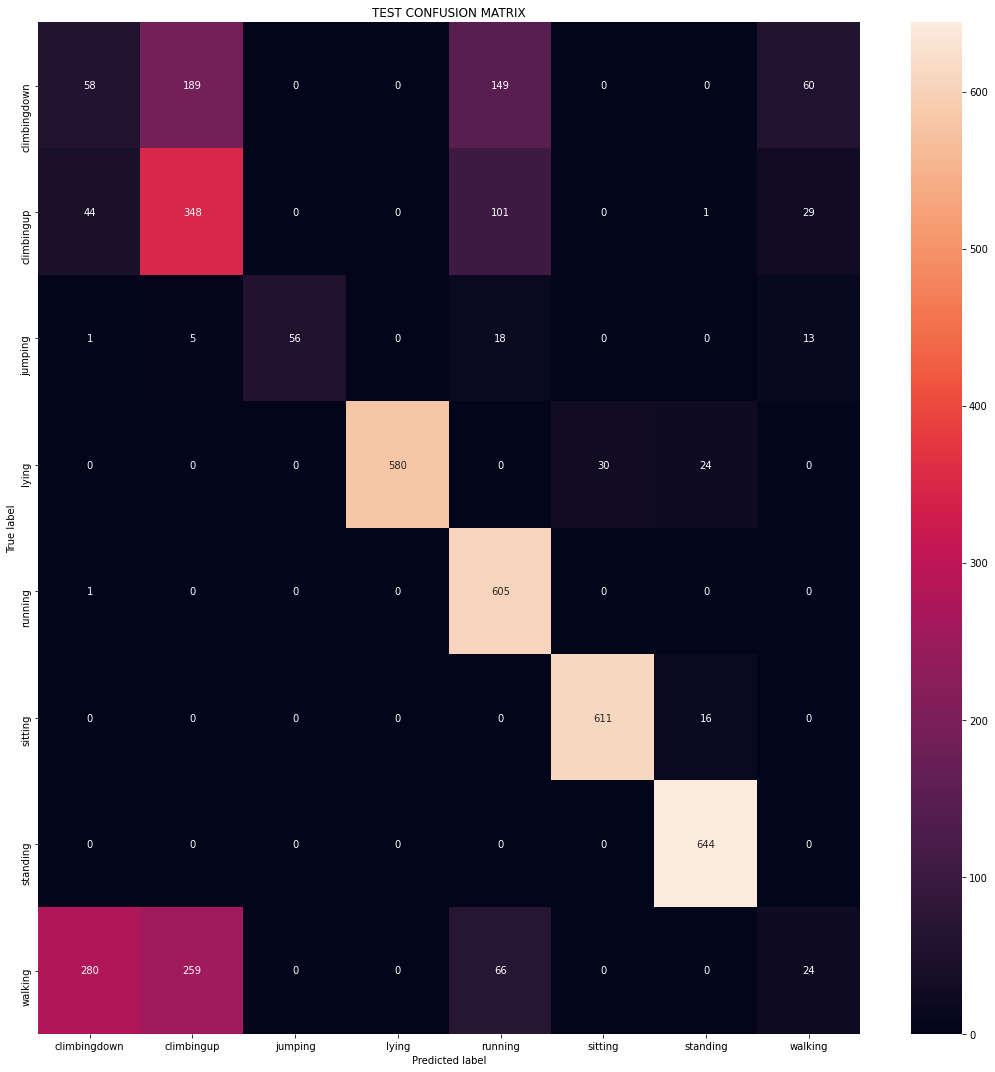

In [54]:
final_model =  RandomForestClassifier(n_estimators = 100, bootstrap='True',max_depth=1000,max_features=6,min_samples_leaf=1,min_samples_split=2, random_state = 42,max_samples=0.2,max_leaf_nodes=28)
implement_model(final_model,'final')